In [1]:
from astropy.io import fits
import glob, os
from subprocess import call
from astropy.io import fits
import time

# jwst
import jwst
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, Spec3Pipeline
from jwst.cube_build import cube_build_step
from jwst import datamodels
import matplotlib.pyplot as plt
import numpy as n

#there are no stage 1 data products from STSci


In [2]:
# Print out what pipeline version we're using
print('JWST pipeline version',jwst.__version__)

JWST pipeline version 1.4.7a1.dev23+g0508e862


In [24]:
cache_dir = './'

det1_dir = 'stage1_dither1/' # Detector1 pipeline outputs will go here
spec2_dir = 'stage2_dither1/' # Spec2 pipeline outputs will go here
spec3_dir = 'stage3_dither1/' # Spec3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)

In [25]:
cal_files = glob.glob('data/*cal.fits')
print(cal_files)
cal_files = cal_files[0:1]
for fname in cal_files:
    print(fname)



## create association file for dithered data. Make a json file for each dither set.
call(["asn_from_list", "-o","MRS_asn_single_dither.json"] + cal_files + ["--product-name", "dither"])  #maybe I dont need this line.

#crds_config = Spec3Pipeline.get_config_from_reference('data/l2_asn.json')

['data/NRS00001-S1S2-F290LP-G395H-01_1_492_SE_2021-10-30T12h15m00_noflat_cal.fits', 'data/NRS00001-S1S2-F290LP-G395H-01_1_491_SE_2021-10-30T12h15m00_noflat_cal.fits', 'data/NRS00001-S1S2-F290LP-G395H-04_1_492_SE_2021-10-30T12h15m00_noflat_cal.fits', 'data/NRS00001-S1S2-F290LP-G395H-04_1_491_SE_2021-10-30T12h15m00_noflat_cal.fits', 'data/NRS00001-S1S2-F290LP-G395H-03_1_492_SE_2021-10-30T12h15m00_noflat_cal.fits', 'data/NRS00001-S1S2-F290LP-G395H-03_1_491_SE_2021-10-30T12h15m00_noflat_cal.fits', 'data/NRS00001-S1S2-F290LP-G395H-02_1_492_SE_2021-10-30T12h15m00_noflat_cal.fits', 'data/NRS00001-S1S2-F290LP-G395H-02_1_491_SE_2021-10-30T12h15m00_noflat_cal.fits']
data/NRS00001-S1S2-F290LP-G395H-01_1_492_SE_2021-10-30T12h15m00_noflat_cal.fits


0

In [ ]:
# This initial setup is just to make sure that we get the latest parameter reference files
# pulled in for our files.  This is a temporary workaround to get around an issue with
# how this pipeline calling method works.
crds_config = Spec3Pipeline.get_config_from_reference('data/l3_asn.json')# The exact asn file used doesn't matter
spec3 = Spec3Pipeline.from_config_section(crds_config)
    
spec3.output_dir = spec3_dir
spec3.save_results = True

spec3.master_background.skip = True # Computes and subtracts a master background signal
spec3.outlier_detection.skip = True # Identifies and flags any pixels with values that produce outliers in overlapping regions of cube space #True skip
spec3.mrs_imatch.skip = False # Ensure that there are no jumps in the background between individual exposures
spec3.cube_build.skip = False # Build the composite data cubes
spec3.extract_1d.skip = False # Extract 1d spectra from the composite data cubes

spec3('data/l3_asn.json')

2022-05-20 12:30:43,113 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2022-05-20 12:30:43,115 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-05-20 12:30:43,116 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2022-05-20 12:30:43,118 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2022-05-20 12:30:43,120 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-05-20 12:30:43,124 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2022-05-20 12:30:43,127 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2022-05-20 12:30:43,130 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2022-05-20 12:30:43,133 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.
2022-05-20 12:30:43,134 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance

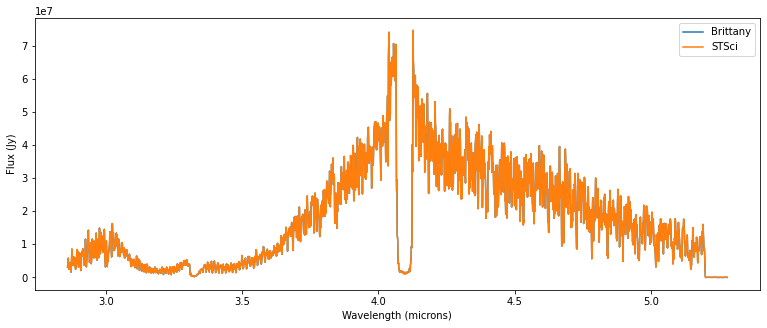

In [3]:
#how I get the data
data = fits.open('stage3_dither1/NRS00001-BrownDwarf-F290LP-G395H_comb_1234_noutlier_g395h-f290lp_x1d.fits')
spectrum_info = data[1].data

wavelength = spectrum_info['WAVELENGTH']
flux = spectrum_info['FLUX'] #jy
#flux_error = spectrum_info['FLUX_ERROR'] #jy


#how I get the data
data2 = fits.open('data/NRS00001-BrownDwarf-F290LP-G395H_comb_1234_noutlier_g395h-f290lp_x1d.fits')
spectrum_info2 = data2[1].data


wavelength2 = spectrum_info2['WAVELENGTH']
flux2 = spectrum_info2['FLUX'] #Jy
flux_error2 = spectrum_info2['FLUX_ERROR'] #Jy

plt.figure(figsize = (13, 5))
plt.plot(wavelength, flux, label = 'Brittany') #7e7
plt.plot(wavelength2, flux2, label = 'STSci') #1.75e6
plt.ylabel('Flux (Jy)')
plt.xlabel('Wavelength (microns)')
plt.legend()
plt.savefig('spectra_comparison.jpg')